<DIV ALIGN=CENTER>

# Introduction to Density Estimation
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore how to effectively use the ensemble
technique of boosting by using Gradient Boosted Trees (GBT). First, we
repeat the analysis of the Iris and hand-written digit data used in the
[DT][l1] and [RF][l2] IPython Notebooks. However, we now switch to the
GBT algorithm. Throughout this Notebook, you should think about how
these results from this algorithm are different than the results from
the other algorithms, in particular the RF algorithm that employs
baggin. Also, explore how changes in the default parameters might affect
the performance of this algorithm, such as using different loss
functions or changing the numebr of estimators.

First, we will setup this Notebook, and then introduce the Iris data,
before making classifications for this data by using the scikit learn's
[Gradient Boosted Trees][gbtsk] algorithm.

-----
[l1]: intro2dt.ipynb
[l2]: intro2rf.ipynb
[gbtsk]: http://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

sns.set(style="white")

# Load the Iris Data
iris = sns.load_dataset("iris")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


-----

## Iris Data

We will use the standard Iris classification data set to explore how to
use ensemble classification algorithms, in this Notebook we focus on
Gradient Boosted Trees, or GBT. The four primary dimensions of the data
include Sepal Length, Sepal Width, Petal Length, and Petal Width, which
can be seen from the following Iris picture (or type _virginica_).

![Iris picture from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/thumb/9/9f/Iris_virginica.jpg/220px-Iris_virginica.jpg)

The data set consists of 150 total measurements of three different types
of Iris flowers, equally divided between three classes: Iris Setosa,
Iris versicolor, and Iris virginica. Before proceeding, we can examine
the Pandas DataFrame that contains these data.

-----

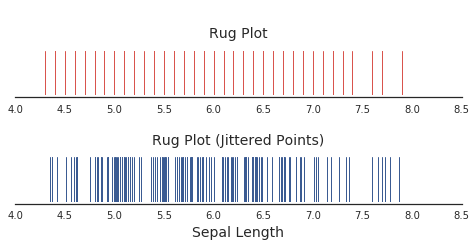

In [2]:
jitter = 0.05
clr = [sns.xkcd_rgb["pale red"], sns.xkcd_rgb["denim blue"]]
ttl = ['Rug Plot', 'Rug Plot (Jittered Points)']

data = []
data.append(iris['sepal_length'])
data.append(iris['sepal_length'] + np.random.normal(0, jitter, len(data[0])))

fig, axs = plt.subplots(figsize=(8, 3.5), nrows=2, ncols=1, sharex=True)

for idx, dat in enumerate(data):
    sns.rugplot(ax = axs[idx], a=dat, height=0.5, c = clr[idx])
    axs[idx].set_yticks([])
    axs[idx].set_xlim(4.0, 8.5)
    axs[idx].set_xlabel('Sepal Length', fontsize=14)
    axs[idx].text(6.25, 0.65, ttl[idx], ha='center', fontsize=14)
    sns.despine(ax=axs[idx], left=True, offset=2, trim=True)

plt.show()

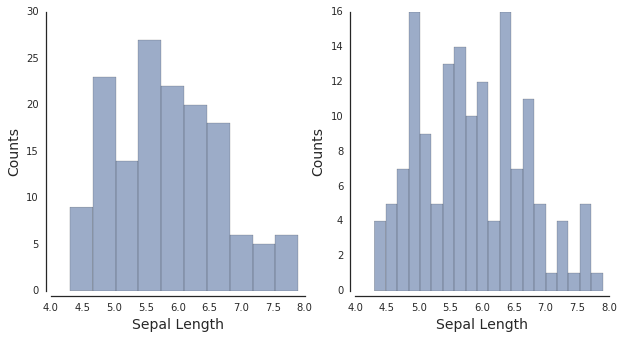

In [3]:
plt.close('all')

nbs = [10, 20]
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

for ax, nb in zip(axs, nbs):
    ax.hist(iris['sepal_length'], bins=nb, alpha=0.5, color=sns.xkcd_rgb["denim blue"])

    ax.set_xlabel('Sepal Length', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)

    sns.despine(ax=ax, offset=5, trim=True)

plt.show()

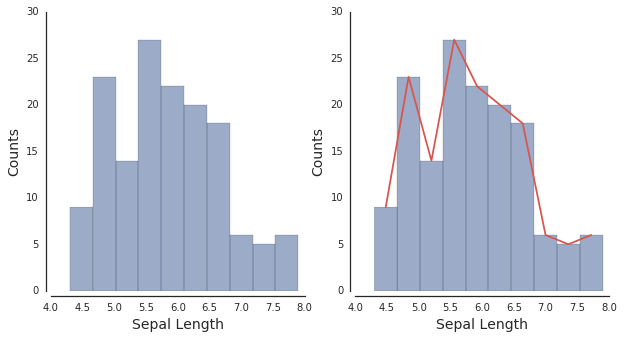

In [4]:
nb = 10
fig, axs = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)

for idx, ax in enumerate(axs):
    n, bins, patches = ax.hist(iris['sepal_length'], bins=nb, \
                               alpha=0.5, color=sns.xkcd_rgb["denim blue"])
    
    ax.set_xlabel('Sepal Length', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    
    if idx:
        bc = bins[:-1] + (bins[1] - bins[0])/2.0
        ax.plot(bc, n, c=sns.xkcd_rgb["pale red"])

    sns.despine(ax=ax, offset=5, trim=True)

plt.show()

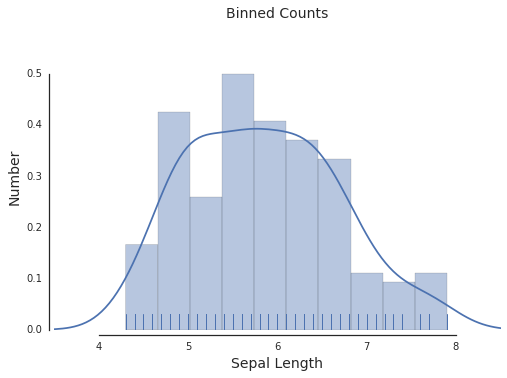

In [5]:
ax = sns.distplot(iris['sepal_length'], kde=True, rug=True, bins=10)
ax.set_xlim(3.5, 8.5)
ax.set_ylim(0, 0.6)

ax.set_xlabel('Sepal Length', fontsize=14)
ax.set_ylabel('Number', fontsize=14)

ax.set_title('Binned Counts', fontsize=14)
sns.despine(offset=5, trim=True)

### Kernel Density Estimation

http://stanford.edu/~mwaskom/software/seaborn/tutorial/distributions.html#kernel-density-estimaton

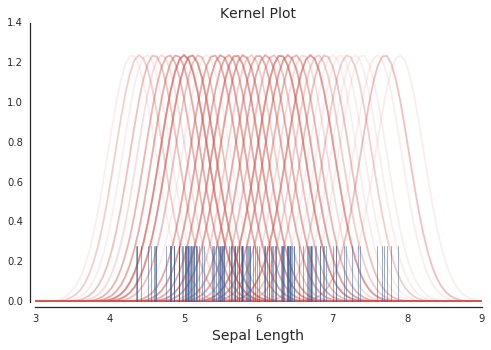

In [6]:
from scipy import stats, integrate

fig, ax = plt.subplots(figsize=(8, 5))

# For kernel Density Estimation, 
# we need a Kernel model and a bandwidth.
# Here we assume a Gaussian Kernel, and the Seaborn bandwidth.

dt = data[0]
bw = 1.06 * dt.std() * len(dt) ** (-1 / 5.)
support = np.linspace(3, 9, 100)

kernels = []
for d in dt:
    kernel = stats.norm(d, bw).pdf(support)
    kernels.append(kernel)
    plt.plot(support, kernel, color=sns.xkcd_rgb["pale red"], alpha = 0.1)

# Now show rugplot as support.
sns.rugplot(data[1], color=sns.xkcd_rgb["denim blue"], \
            height=0.2, linewidth=1, alpha = 0.5)
plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Plot', fontsize=14)

sns.despine(offset=5, trim=True)

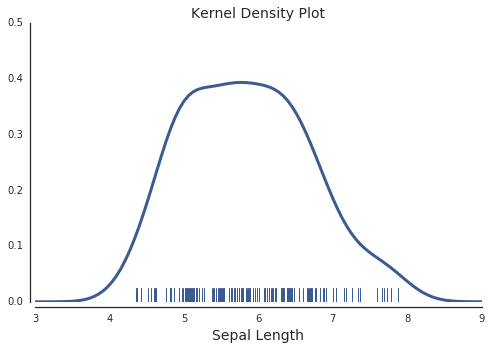

In [7]:
fig, ax = plt.subplots(figsize=(8, 5))

# To compute kernel density estimate, we sum up the individual kernels and 
# normalize by total area.

density = np.sum(kernels, axis=0)
density /= integrate.trapz(density, support)
plt.plot(support, density, color=sns.xkcd_rgb["denim blue"], linewidth=3)
plt.ylim(0.0, 0.5)

# Now show rugplot as support.
sns.rugplot(data[1], color=sns.xkcd_rgb["denim blue"], linewidth=1)
plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Density Plot', fontsize=14)

sns.despine(offset=5, trim=True)

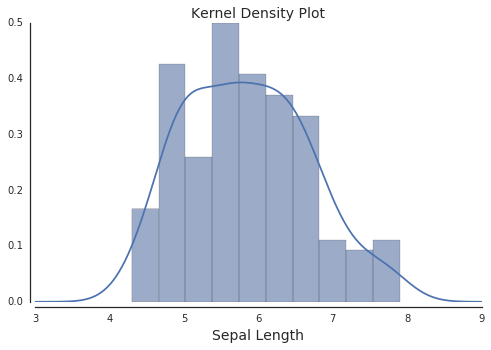

In [8]:
from sklearn.neighbors import KernelDensity

# Gaussian KDE with Seaborn bandwidth
kde = KernelDensity(kernel='gaussian', bandwidth=bw)

x = data[0]
support = np.linspace(3, 9, len(x))

kde.fit(x[:, np.newaxis])
y = kde.score_samples(support[:, np.newaxis])

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(x, bins=10, alpha=0.5, color=sns.xkcd_rgb["denim blue"], normed=True)
ax.plot(support, np.exp(y))
plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Density Plot', fontsize=14)

sns.despine(offset=5, trim=True)
plt.show()

In [9]:
# We can now sample from the KDE model
for val in kde.sample(n_samples=5):
    print('{0:4.1f}, '.format(val[0]), end='')

 7.7,  6.0,  6.6,  3.8,  4.9, 

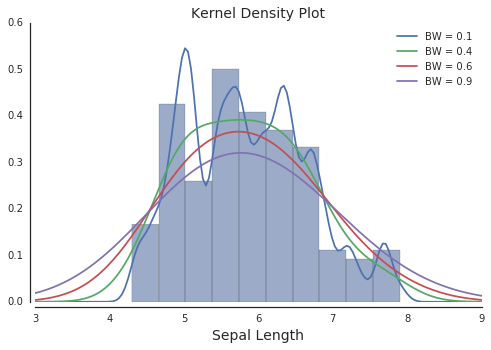

In [10]:
from sklearn.neighbors import KernelDensity

# Gaussian KDE with Seaborn bandwidth

fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(x, bins=10, alpha=0.5, color=sns.xkcd_rgb["denim blue"], normed=True, label='')

for bw in np.linspace(0.1, 0.9, 4):
    kde = KernelDensity(kernel='gaussian', bandwidth=bw)
    kde.fit(x[:, np.newaxis])
    y = kde.score_samples(support[:, np.newaxis])
    ax.plot(support, np.exp(y), label='BW = {0:3.1f}'.format(bw))

plt.xlabel('Sepal Length', fontsize=14)
plt.title('Kernel Density Plot', fontsize=14)
plt.legend()

sns.despine(offset=5, trim=True)
plt.show()

-----

## Student Activity

In the preceding cells, we used an ensemble GBT model to predict
classifications for the Iris Data. Now that you have run this Notebook
once, go back and make the following changes to see how the results
change.

1. Change the cross-validation split size, for example change from a
75%:25% to a 50%:50%?
2. Change the default parameters in the GBT algorithm, for example, the
`loss`, `learning_rate`, `n_estimators`, `subsample`, and
`max_features`. Read the code documentation to learn about the default
parameters.


How does the two-dimensional figure compare to the same figure in the RF Notebook?

-----

----

## Multi-variate KDE

-----

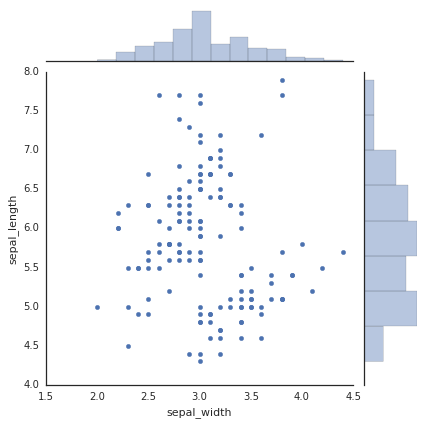

In [11]:
ax = sns.jointplot(x='sepal_width', y='sepal_length', data=iris, stat_func=None)

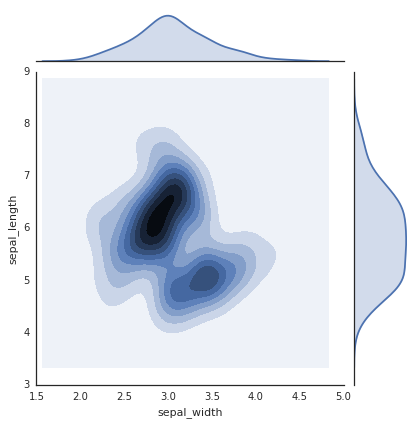

In [12]:
ax = sns.jointplot(x='sepal_width', y='sepal_length', data=iris, kind='kde', stat_func=None)

## Handwritten Digits

Now we switch to a second type of data and explore GBT classification
applied to handwritten digits. First we will load the data and review
some of the sample. After which, we will apply a GBT model to these data
and explore the resulting predictions.

Example from [scikit-learn documentatiomn][sk-kde].

-----
[sk-kde]: http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html#example-neighbors-plot-digits-kde-sampling-py

Total number of samples = 1797


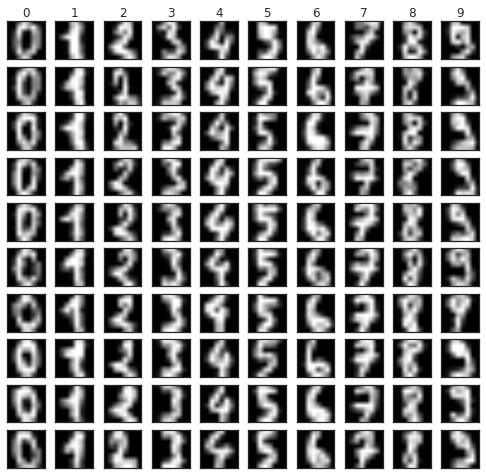

In [13]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print('Total number of samples = {0}'.format(y.shape[0]))

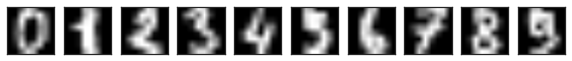

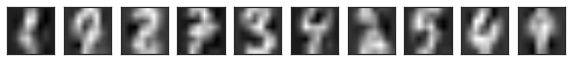

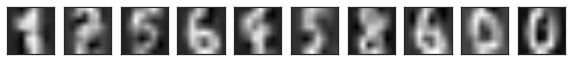

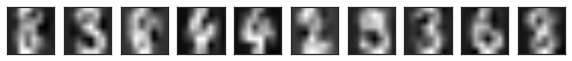

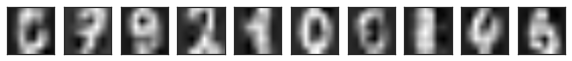

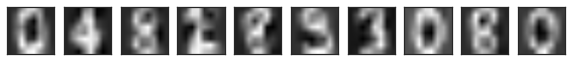

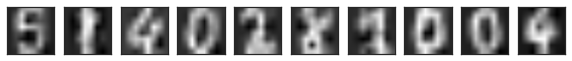

In [14]:
# Testing parameters
ncps = 20
bw = 4.0 # Could do grid search to determine
nimgs = 60 # Multiple of ten

# Compute PCA for digit data
pca = PCA(n_components=ncps, copy=True)
data = pca.fit_transform(x)

# Compute KDE for PCAs
kde = KernelDensity(bandwidth=3)
kde.fit(data)

# Sample from model, and recover full image
new_data = kde.sample(nimgs, random_state=42)
new_data = pca.inverse_transform(new_data)

# Plot input data
hd.plot_numbers(x[:10])

for idx in range(0, nimgs, 10):
    hd.plot_numbers(new_data[0 + idx:10 + idx])

-----

## Student Activity

In the preceding cells, we used a Gradient Boosted Tree model to predict
classifications for the digit data. Now that you have run the Notebook,
go back and make the following changes to see how the results change.

1. Change the cross-validation split size, for example change from a
75%:25% to a 50%:50%?
2. Change the default parameters in the GBT, for example `loss` and
`learning_rate`. Read the code documentation to learn about the default
parameters.
3. Change the metric in the accuracy plot, for example, use `f1_score`.
How did the results change? Trying changing the parameters in the GBT
classifier and seeing how the accuracy is altered.

Finally can you explain (feel free to use the class forums) why the
model performed in the  manner it did for the _fake_ digits? How did
this compare to the RF model?

-----

# Plot Tornado paths on basemap?